In [131]:
"""
Utility function for PointConv
Originally from : https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/utils.py
Modify by Wenxuan Wu
Date: September 2019
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x
    
def PE(x, L):
    
    #位置编码 低频信息转换为高频信息-  x代表输入给编码器的数据维度，也就是3，2,5， l为数学公式中的L
    #这个函数对x坐标的3个值和向量d 的2个值都进行了编码。实验中设置了 L=10 for y(x)，L=4 for y（d）
    #这里为了方便统一处理，应该会影响最后效果
    
    pai = 3.14
    pe = []
    for i in range(L):
        for fn in [torch.sin, torch.cos]:#依次 先后读取sin cos 函数
            pe.append(fn(2.**i * x * pai))
    return torch.cat(pe, -1)  #对tensor 进行拼接
    

    
def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
#     print('src.shape',src.shape)
#     print('dst.shape',dst.shape)
    
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, C]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    #import ipdb; ipdb.set_trace()
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    #farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    farthest = torch.zeros(B, dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 2)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx

def knn_point(nsample, xyz, new_xyz):
    """
    Input:
        nsample: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, nsample, dim = -1, largest=False, sorted=False)
    return group_idx

def sample_and_group(npoint, nsample, xyz, points, density_scale = None):
    """
    Input:
        npoint:
        nsample:
        xyz: input points position data, [B, N, C]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, C]
        new_points: sampled points data, [B, 1, N, C+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = knn_point(nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
    
    
    
    print('xyz {}, points {},'.format(xyz.shape, points.shape))
    print('new_xyz {}'.format(new_xyz.shape))
    print('grouped_xyz {}, grouped_xyz_norm {},'.format(grouped_xyz.shape, grouped_xyz_norm.shape))
    '''
    xyz torch.Size([8, 200, 2]), points torch.Size([8, 200, 2]),
    new_xyz torch.Size([8, 96, 2])
    grouped_xyz torch.Size([8, 96, 64, 2]), grouped_xyz_norm torch.Size([8, 96, 64, 2]),
    
    '''
    
    '''
    grouped means [pi - p0]
    
    '''
    
    
    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm

    if density_scale is None:
        return new_xyz, new_points, grouped_xyz_norm, idx
    else:
        grouped_density = index_points(density_scale, idx)
        return new_xyz, new_points, grouped_xyz_norm, idx, grouped_density

def sample_and_group_all(xyz, points, density_scale = None):
    """
    Input:
        xyz: input points position data, [B, N, C]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, C]
        new_points: sampled points data, [B, 1, N, C+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    #new_xyz = torch.zeros(B, 1, C).to(device)
    new_xyz = xyz.mean(dim = 1, keepdim = True)
    grouped_xyz = xyz.view(B, 1, N, C) - new_xyz.view(B, 1, 1, C)  
    
    
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    if density_scale is None:
        return new_xyz, new_points, grouped_xyz
    else:
        grouped_density = density_scale.view(B, 1, N, 1)
        return new_xyz, new_points, grouped_xyz, grouped_density

def group(nsample, xyz, points):
    """
    Input:
        npoint:
        nsample:
        xyz: input points position data, [B, N, C]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, C]
        new_points: sampled points data, [B, 1, N, C+D]
    """
    B, N, C = xyz.shape
    S = N
    new_xyz = xyz
    idx = knn_point(nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm

    return new_points, grouped_xyz_norm

def compute_density(xyz, bandwidth):
    '''
    xyz: input points position data, [B, N, C]
    '''
    #import ipdb; ipdb.set_trace()
    B, N, C = xyz.shape
    sqrdists = square_distance(xyz, xyz)
    gaussion_density = torch.exp(- sqrdists / (2.0 * bandwidth * bandwidth)) / (2.5 * bandwidth)
#     print('gaussion_density',gaussion_density.shape)
    xyz_density = gaussion_density.mean(dim = -1)

    return xyz_density

class DensityNet(nn.Module):
    def __init__(self, hidden_unit = [16, 8]):
        super(DensityNet, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList() 

        self.mlp_convs.append(nn.Conv2d(1, hidden_unit[0], 1))
        self.mlp_bns.append(nn.BatchNorm2d(hidden_unit[0]))
        for i in range(1, len(hidden_unit)):
            self.mlp_convs.append(nn.Conv2d(hidden_unit[i - 1], hidden_unit[i], 1))
            self.mlp_bns.append(nn.BatchNorm2d(hidden_unit[i]))
        self.mlp_convs.append(nn.Conv2d(hidden_unit[-1], 1, 1))
        self.mlp_bns.append(nn.BatchNorm2d(1))

    def forward(self, density_scale):
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            density_scale =  bn(conv(density_scale))
            if i == len(self.mlp_convs):
                density_scale = F.sigmoid(density_scale)
            else:
                density_scale = F.gelu(density_scale)
        
        return density_scale

class WeightNet(nn.Module):

    def __init__(self, in_channel, out_channel, hidden_unit = [8, 8]):
        super(WeightNet, self).__init__()

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        if hidden_unit is None or len(hidden_unit) == 0:
            self.mlp_convs.append(nn.Conv2d(in_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
        else:
            self.mlp_convs.append(nn.Conv2d(in_channel, hidden_unit[0], 1))
            self.mlp_bns.append(nn.BatchNorm2d(hidden_unit[0]))
            for i in range(1, len(hidden_unit)):
                self.mlp_convs.append(nn.Conv2d(hidden_unit[i - 1], hidden_unit[i], 1))
                self.mlp_bns.append(nn.BatchNorm2d(hidden_unit[i]))
            self.mlp_convs.append(nn.Conv2d(hidden_unit[-1], out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
        
    def forward(self, localized_xyz):
        #xyz : BxCxKxN

        weights = localized_xyz
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            weights =  F.gelu(bn(conv(weights)))

        return weights

class PointConvSetAbstraction(nn.Module):
    def __init__(self, npoint, nsample, in_channel, mlp, group_all):
        super(PointConvSetAbstraction, self).__init__()
        self.npoint = npoint
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

        self.weightnet = WeightNet(3, 16)
        self.linear = nn.Linear(16 * mlp[-1], mlp[-1])
        self.bn_linear = nn.BatchNorm1d(mlp[-1])
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        B = xyz.shape[0]
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points, grouped_xyz_norm = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points, grouped_xyz_norm, _ = sample_and_group(self.npoint, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.gelu(bn(conv(new_points)))

        grouped_xyz = grouped_xyz_norm.permute(0, 3, 2, 1)
        weights = self.weightnet(grouped_xyz)
        new_points = torch.matmul(input=new_points.permute(0, 3, 1, 2), other = weights.permute(0, 3, 2, 1)).view(B, self.npoint, -1)
        new_points = self.linear(new_points)
        new_points = self.bn_linear(new_points.permute(0, 2, 1))
        new_points = F.gelu(new_points)
        new_xyz = new_xyz.permute(0, 2, 1)

        return new_xyz, new_points

class PointConvDensitySetAbstraction(nn.Module):
    def __init__(self, npoint, nsample, in_channel, mlp, bandwidth, group_all):
        super(PointConvDensitySetAbstraction, self).__init__()
        self.npoint = npoint
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

        self.weightnet = WeightNet(2, 16)
        self.linear = nn.Linear(16 * mlp[-1], mlp[-1])
        self.bn_linear = nn.BatchNorm1d(mlp[-1])
        self.densitynet = DensityNet()
        self.group_all = group_all
        self.bandwidth = bandwidth

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        B = xyz.shape[0]
        N = xyz.shape[2]
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        xyz_density = compute_density(xyz, self.bandwidth)
        inverse_density = 1.0 / xyz_density 
        print('inverse_density',inverse_density.shape)

        if self.group_all:
            new_xyz, new_points, grouped_xyz_norm, grouped_density = sample_and_group_all(xyz, points, inverse_density.view(B, N, 1))
        else:
            new_xyz, new_points, grouped_xyz_norm, _, grouped_density = sample_and_group(self.npoint, self.nsample, xyz, points, inverse_density.view(B, N, 1))
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        print(new_points.size())
        
        print('grouped_density',grouped_density.shape)
        
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.gelu(bn(conv(new_points)))
        print(new_points.size())
        
        inverse_max_density = grouped_density.max(dim = 2, keepdim=True)[0]
        density_scale = grouped_density / inverse_max_density
        density_scale = self.densitynet(density_scale.permute(0, 3, 2, 1))
        new_points = new_points * density_scale

        grouped_xyz = grouped_xyz_norm.permute(0, 3, 2, 1)
        weights = self.weightnet(grouped_xyz)     
        new_points = torch.matmul(input=new_points.permute(0, 3, 1, 2), other = weights.permute(0, 3, 2, 1)).view(B, self.npoint, -1)
        new_points = self.linear(new_points)
        new_points = self.bn_linear(new_points.permute(0, 2, 1))
        new_points = F.gelu(new_points)
        new_xyz = new_xyz.permute(0, 2, 1)

        return new_xyz, new_points

        

In [181]:
def peri_query_ball_point(radius, nsample, xyz, new_xyz): 
    # xyz:      输入点的 xy 坐标 
    # points：  输入点的特征
    # new_xyz:  所求点的 xy 坐标，只在Pe_NO最后一层 new_xyz对应所求像素点
    
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
#     print('xyz',xyz.shape)
#     print('new_xyz',new_xyz.shape)
#     print('nsample',nsample)
    
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    
    group_idx[sqrdists > radius ** 2] = N
    group_idx[sqrdists < 1e-8] = N
    
    
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def peri_sample_and_group(nsample, xyz, points, density_scale = None, final_xyz = None):
    
    # xyz:      输入点的 xy 坐标 
    # points：  输入点的特征
    # final_xyz:  所求点的 xy 坐标，只在Pe_NO最后一层 new_xyz对应所求像素点
    
    """
    Input:
        npoint: N <- B, N, C = xyz.shape
        nsample: 30?
        xyz: input points position data, [B, N, C]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, C]
        new_points: sampled points data, [B, 1, N, C+D]
    """
#     fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
#     new_xyz = index_points(xyz, fps_idx)
#     new_xyz = xyz.clone().detach()
#     points = xyz.clone().detach()


    B, N, C = xyz.shape
#     npoint = N 
#     S = npoint

    if final_xyz is not None:
        _,S,_ = final_xyz.shape #  npoint = S
        idx = peri_query_ball_point(0.15, nsample, xyz, final_xyz)
        grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
        grouped_xyz_norm = grouped_xyz - final_xyz.view(B, S, 1, C)
        
    else:
        npoint = N 
        S = npoint
        idx = peri_query_ball_point(0.15, nsample, xyz, xyz)
        grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
        grouped_xyz_norm = grouped_xyz - xyz.view(B, S, 1, C)
        
#         np.save("filename1.npy",grouped_xyz)
#         np.save("filename2.npy",xyz)
    
    
    grouped_points = index_points(points, idx)
    
    # PE grouped_xyz_norm -> grouped_xyz_norm_PE
    
    grouped_xyz_norm_flat = torch.reshape(grouped_xyz_norm, [-1, 2])
    grouped_xyz_norm_PE = PE(grouped_xyz_norm_flat, L=3).reshape([B, S, nsample,-1]) # 2*2*3=12
    
#     new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    new_points = torch.cat([grouped_xyz_norm_PE, grouped_points], dim=-1)
    grouped_density = index_points(density_scale, idx)
    
    if final_xyz is not None:
        return final_xyz, new_points, grouped_xyz_norm, idx, grouped_density
    else:
        return xyz, new_points, grouped_xyz_norm, idx, grouped_density

In [195]:
class Peri(nn.Module):
    def __init__(self, nsample, in_channel, mlp, bandwidth):
        super(Peri, self).__init__()
        
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

        self.weightnet = WeightNet(2, 16)
        self.linear = nn.Linear(16 * mlp[-1], mlp[-1])
        self.bn_linear = nn.BatchNorm1d(mlp[-1])
        self.densitynet = DensityNet()
        self.bandwidth = bandwidth

    def forward(self, xyz, points, final_xyz = None):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
            final_xyz:  所求点的 xy 坐标，只在Pe_NO最后一层 final_xyz 对应所求像素点
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        B = xyz.shape[0]
        N = xyz.shape[2]
        xyz = xyz.permute(0, 2, 1)  # [B, N, C]
        
        
        if points is not None:
            points = points.permute(0, 2, 1) # [B, N, D]

        xyz_density = compute_density(xyz, self.bandwidth)
        inverse_density = 1.0 / xyz_density 
        if final_xyz is not None:
#             print('1')
            final_xyz = final_xyz.permute(0, 2, 1) # [B, N, C]
            B_, N_, C_ = final_xyz.shape
            npoint = N_ 
            new_xyz, new_points, grouped_xyz_norm, _, grouped_density = peri_sample_and_group(self.nsample, xyz, points, inverse_density.view(B, N, 1),final_xyz)
        else:
#             print('2')
            B_, N_, C_ = xyz.shape
            npoint = N_ 
            new_xyz, new_points, grouped_xyz_norm, _, grouped_density = peri_sample_and_group(self.nsample, xyz, points, inverse_density.view(B, N, 1))
        
        # new_xyz, new_points, grouped_xyz_norm, _, grouped_density = sample_and_group(self.npoint, self.nsample, xyz, points, inverse_density.view(B, N, 1))
        
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample, npoint]
#         print('new_points',new_points.size())
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.gelu(bn(conv(new_points)))
#         print('new_points_',new_points.size())
        
        inverse_max_density = grouped_density.max(dim = 2, keepdim=True)[0]
        density_scale = grouped_density / inverse_max_density
        density_scale = self.densitynet(density_scale.permute(0, 3, 2, 1))
        new_points = new_points * density_scale
        
        
#         print('new_points torch.Size',new_points.permute(0, 3, 1, 2).shape)

        grouped_xyz = grouped_xyz_norm.permute(0, 3, 2, 1)
        weights = self.weightnet(grouped_xyz)   
        
#         print('weights torch.Size',weights.permute(0, 3, 2, 1).shape)
        
        
        new_points = torch.matmul(input=new_points.permute(0, 3, 1, 2), other = weights.permute(0, 3, 2, 1)).view(B, npoint, -1)
        
#         print('new_points',new_points.shape)
        
        new_points = self.linear(new_points)
        new_points = self.bn_linear(new_points.permute(0, 2, 1))
        new_points = F.gelu(new_points)
        new_xyz = new_xyz.permute(0, 2, 1)

        return new_xyz, new_points


In [196]:
sa1 = Peri(nsample=32, in_channel= 3*2*2 + 3, mlp=[8, 8, 6], bandwidth = 0.1)

In [197]:
xyz = torch.rand((1,2,500))
points = torch.rand((1,3,500))
final_xyz = torch.rand((1,2,360))
# new_xyz, new_points = sa1(xyz,points,final_xyz)
new_xyz, new_points = sa1(xyz,points)

In [185]:
print(new_xyz.shape)
print(new_points.shape)

torch.Size([1, 2, 500])
torch.Size([1, 6, 500])


In [186]:
# self.p = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
# self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

In [198]:
class Peri_NO2d(nn.Module):
    def __init__(self, feature_dim):
        super(Peri_NO2d, self).__init__()
        
        self.peri_1 = Peri(nsample=32, in_channel= 2*2*3 + feature_dim, mlp=[8, 8, 6], bandwidth = 0.1)
        self.peri_2 = Peri(nsample=32, in_channel= 2*2*3 + 6, mlp=[8, 8, 6], bandwidth = 0.1)
        self.peri_3 = Peri(nsample=32, in_channel= 2*2*3 + 6, mlp=[8, 8, 6, 1], bandwidth = 0.1)
        
        self.w0 = nn.Conv2d(6, 6, 1)
        
    def forward(self, xyz,points,final_xyz):
        B, _, _ = xyz.shape
        p1_xyz, p1_points = self.peri_1(xyz,points)
        
        B_,C_,N_ = p1_points.shape
        a = self.w0(p1_points.view(B_,C_,N_,1))
#         print(a.shape)
        
        p2_xyz, p2_points = self.peri_2(p1_xyz, p1_points)
        p3_xyz, p3_points = self.peri_3(p2_xyz, p2_points, final_xyz)
        
        return p3_xyz, p3_points


#     def forward(self, xyz, feat):
#         B, _, _ = xyz.shape
#         l1_xyz, l1_points = self.sa1(xyz, feat)
#         l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
#         l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
#         x = l3_points.view(B, 1024)
#         x = self.drop1(F.gelu(self.bn1(self.fc1(x))))
#         x = self.drop2(F.gelu(self.bn2(self.fc2(x))))
#         x = self.fc3(x)
#         x = F.log_softmax(x, -1)
#         return x


In [199]:
def get_final_xyz(size_x, size_y,batchsize=1):
    
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])

    gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    
    return torch.cat((gridx, gridy), dim=-1).reshape(1,-1,2)
    
final_xyz = get_final_xyz(64,64)

In [200]:
# pts_flat = torch.reshape(pts, [-1, 2])
# pts_flat = PE(pts_flat, L=4)
# pts_flat.shape

In [201]:
# FNO      激活函数，跳跃连接，升降维，网格
# NeRF     PE,Resample

In [202]:
model = Peri_NO2d(feature_dim = 3)

xyz = torch.rand((1,2,5000))
points = torch.rand((1,3,5000))
# final_xyz = torch.rand((1,2,360))
final_xyz = get_final_xyz(64,64).permute(0,2,1)

new_xyz, new_points = model(xyz,points,final_xyz)

In [203]:
print(new_xyz.shape)
print(new_points.shape)

torch.Size([1, 2, 4096])
torch.Size([1, 1, 4096])


torch.Size([64])

In [ ]:
class Peri_NO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(Peri_NO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        print(x.shape)
        grid = self.get_grid(x.shape, x.device)
        print('grid',grid.shape)
        # print('griddddddddd',grid)

        x = torch.cat((x, grid), dim=-1)
        print('x1', x.shape)
        x = self.p(x)
        print('p1', x.shape)
        x = x.permute(0, 3, 1, 2)
        print('x11', x.shape)
        x = F.pad(x, [0,self.padding, 0,self.padding])
        print('x1212', x.shape)

        x1 = self.conv0(x)
        print('x12', x.shape)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        print('x33', x.shape)
        x = x[..., :-self.padding, :-self.padding]
        print('x34', x.shape)
        x = self.q(x)
        print('x35', x.shape)
        x = x.permute(0, 2, 3, 1)
        print('x36', x.shape)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        print('xx',gridx.shape)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        print('xx',gridx.shape)
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        print('yy', gridx.shape)
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [26]:
xyz = torch.rand((1,2,500))
points = torch.rand((1,3,500))
final_xyz = torch.rand((1,2,360))
# new_xyz, new_points = sa1(xyz,points,final_xyz)
new_xyz, new_points = sa1(xyz,points)

In [27]:
print(new_xyz.shape)
print(new_points.shape)

torch.Size([1, 2, 500])
torch.Size([1, 8, 500])


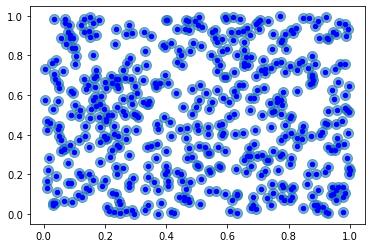

In [28]:
plt.scatter(new_xyz[0,0,:],new_xyz[0,1,:],s=100,alpha=0.6)
plt.scatter(xyz[0,0,:],xyz[0,1,:],s=20,c='b')

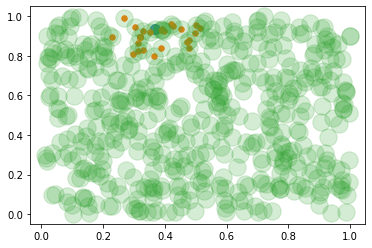

In [29]:
grouped_xyz = np.load("filename1.npy")
xyz  = np.load("filename2.npy")

test_num = 70
plt.scatter(xyz[0][test_num,0],xyz[0][test_num,1],s=100,alpha=0.8)
plt.scatter(grouped_xyz[0][test_num,:,0],grouped_xyz[0][test_num,:,1],s=30)
plt.scatter(xyz[0][:,0],xyz[0][:,1],s=300,alpha=0.2)

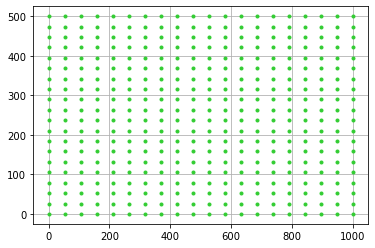

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1000,20)
y = np.linspace(0,500,20)

X,Y = np.meshgrid(x, y)

plt.plot(X, Y,
   color='limegreen', # 设置颜色为limegreen
   marker='.', # 设置点类型为圆点
   linestyle='') # 设置线型为空，也即没有线连接点
plt.grid(True)
plt.show()

In [13]:
pixel = 64
x = np.linspace(0,1,pixel+1)
x += 0.5*(x[1]-x[0])

In [ ]:
def get_grid(self, shape, device):
    batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    print('xx',gridx.shape)
    gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    print('xx',gridx.shape)
    gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    print('yy', gridx.shape)
    return torch.cat((gridx, gridy), dim=-1).to(device)

################################################################
# configs
################################################################
# TRAIN_PATH = 'data/piececonst_r421_N1024_smooth1.mat'
# TEST_PATH = 'data/piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 1
learning_rate = 0.001
epochs = 500
iterations = epochs*(ntrain//batch_size)

solution = h
model = FNO2d(modes, modes, width)
####### test ########
# x = torch.rand(8,64,64,1)
# # x = torch.rand(1,4,3,4)
# print('x', x.shape)
# model = FNO2d(modes, modes, width)
# y = model(x)
#######

# ################################################################
# # load data and data normalization
# ################################################################
# reader = MatReader(TRAIN_PATH)
# x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
# y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]
#
# reader.load_file(TEST_PATH)
# x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s]
# y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s]
#

x_train = torch.randn(8,s,s,1)
x_test = torch.randn(8,s,s,1)

y_train = torch.randn(8,s,s,1)
y_test = torch.randn(8,s,s,1)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_train = x_normalizer.encode(x_train)
# x_test = x_normalizer.encode(x_test)
#
# y_normalizer = UnitGaussianNormalizer(y_train)
# y_train = y_normalizer.encode(y_train)
#
# x_train = x_train.reshape(ntrain,s,s,1)
# x_test = x_test.reshape(ntest,s,s,1)
#
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
#
# ################################################################
# # training and evaluation
# ################################################################



# print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
loss_function = nn.MSELoss()
# myloss = LpLoss(size_average=False)
# y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        # x, y = x.cuda(), y.cuda()
        x = torch.cat((x,x),dim=-1)
        x = torch.unique(x, sorted=False, dim=-1)

        optimizer.zero_grad()
        out = model(x)
        print('outshape',out.shape)
        out = out.reshape(8, s, s)
        # out = y_normalizer.decode(out)
        # y = y_normalizer.decode(y)
        loss = loss_function(out.view(batch_size, -1), y.view(batch_size, -1))
        # loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        scheduler.step()
        train_l2 += loss.item()

    # model.eval()
    # test_l2 = 0.0
    # with torch.no_grad():
    #     for x, y in test_loader:
    #         x, y = x.cuda(), y.cuda()
    #
    #         out = model(x).reshape(batch_size, s, s)
    #         out = y_normalizer.decode(out)
    #
    #         test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
    #
    # train_l2/= ntrain
    # test_l2 /= ntest
    #
    # t2 = default_timer()
    # print(ep, t2-t1, train_l2, test_l2)